<a href="https://colab.research.google.com/github/Tamar-m/DeepLearningClass/blob/main/Fashion_MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Set random seed for reproducibility
torch.manual_seed(42)

# Select and display device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device.type)

Device in use: cuda


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)


class Generator(nn.Module):
    def __init__(self, num_features):
        super(Generator, self).__init__()

        self.fc = nn.Linear(num_features, 7*7*128)
        self.relu = nn.ReLU()
        self.bn1d = nn.BatchNorm1d(7*7*128)

        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn1d(x)
        x = x.view(x.size(0), 128, 7, 7)   # Reshape the tensor to match the expected input shape
        x = self.conv_transpose(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr =  0.001
batch_size = 32
num_features = 100
num_epochs = 50

In [ ]:
# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize the discriminator and generator
discriminator = Discriminator().to(device)
generator = Generator(num_features).to(device)

# Define the loss functions
criterion = nn.BCELoss()

# Define the optimizers for discriminator and generator
optim_discriminator = optim.RMSprop(discriminator.parameters(), lr=lr,  alpha=0.9, eps=1e-07)
optim_generator = optim.RMSprop(generator.parameters(), lr=lr, alpha=0.9, eps=1e-07)

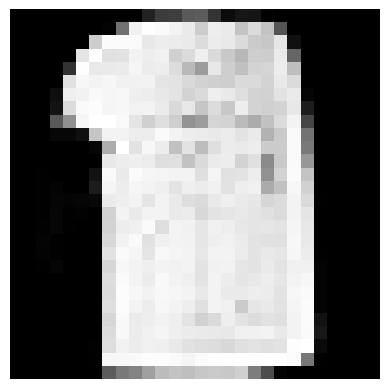

In [ ]:
# test generator output with no training
generator.eval()
noise = torch.randn(1, num_features).to(device)
with torch.no_grad():
  generated_image = generator(noise).detach().cpu().numpy()
plt.imshow(generated_image[0,0,:,:],cmap = 'gray')
plt.axis("off")
plt.show()


In [ ]:
# Training loop
losses_d = []
losses_g = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    epochLossG = 0
    epochLossD = 0
    for batch_idx, (real, _) in enumerate(train_loader):

        real = real.to(device)
        batch_size = real.shape[0]

        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, num_features).to(device)
        fake = generator(noise)
        disc_real = discriminator(real).reshape(-1)
        loss_d_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach()).reshape(-1)
        loss_d_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_d = (loss_d_real + loss_d_fake) / 2

        discriminator.zero_grad()
        loss_d.backward()
        optim_discriminator.step()

        # Train Generator: maximize log(D(G(z)))
        output = discriminator(fake).reshape(-1)
        loss_g = criterion(output, torch.ones_like(output))

        generator.zero_grad()
        loss_g.backward()
        optim_generator.step()

        # Save losses
        losses_d.append(loss_d.item())
        losses_g.append(loss_g.item())

        epochLossD += loss_d
        epochLossG += loss_g

        if batch_idx % 200 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} "
                f"Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}"
            )

Epoch [0/50] Batch 0/1875 Loss D: 0.7017, Loss G: 1.1081
Epoch [0/50] Batch 200/1875 Loss D: 0.5408, Loss G: 0.9118
Epoch [0/50] Batch 400/1875 Loss D: 0.5821, Loss G: 1.0289
Epoch [0/50] Batch 600/1875 Loss D: 0.3488, Loss G: 1.3688
Epoch [0/50] Batch 800/1875 Loss D: 0.3593, Loss G: 1.6416
Epoch [0/50] Batch 1000/1875 Loss D: 0.4643, Loss G: 2.2506
Epoch [0/50] Batch 1200/1875 Loss D: 0.3295, Loss G: 2.2055
Epoch [0/50] Batch 1400/1875 Loss D: 0.5333, Loss G: 2.5173
Epoch [0/50] Batch 1600/1875 Loss D: 0.5528, Loss G: 1.7678
Epoch [0/50] Batch 1800/1875 Loss D: 0.4530, Loss G: 1.5748
Epoch [1/50] Batch 0/1875 Loss D: 0.4478, Loss G: 1.4265
Epoch [1/50] Batch 200/1875 Loss D: 0.5528, Loss G: 1.7659
Epoch [1/50] Batch 400/1875 Loss D: 0.4970, Loss G: 1.1872
Epoch [1/50] Batch 600/1875 Loss D: 0.4632, Loss G: 1.6003
Epoch [1/50] Batch 800/1875 Loss D: 0.6480, Loss G: 0.9504
Epoch [1/50] Batch 1000/1875 Loss D: 0.5487, Loss G: 0.8663
Epoch [1/50] Batch 1200/1875 Loss D: 0.6175, Loss G: 1

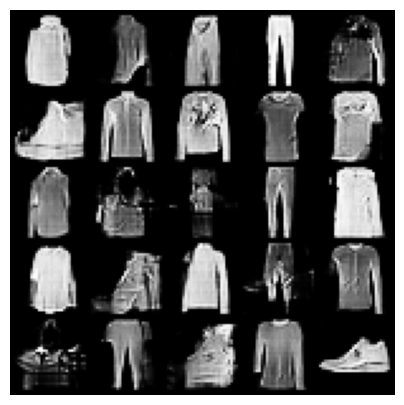

In [ ]:
# Generate and visualize samples from the generator
def visualize_samples(generator, num_features, device, num_samples=batch_size):
    generator.eval()  # Set the generator to evaluation mode

    # Generate random noise vector
    noise = torch.randn(num_samples, num_features).to(device)

    # Generate samples from the generator
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    # Rescale generated images to a range of [0, 1]
    # generated_images = (generated_images + 1) / 2

    # Create a grid of generated images
    grid = vutils.make_grid(generated_images, nrow=int(num_samples ** 0.5), normalize=True)

    # Visualize the grid of generated images
    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

visualize_samples(generator, num_features, device, num_samples=25)